$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$
$$\newcommand{\bra}[1]{\left\langle{#1}\right|}$$
$$\newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}$$

# Examples of using pyCCE code

In [1]:
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('/home/onizhuk/codes_development/pyCCE')
import pycce as pc
import pycce_jit as pcj

# Install a pip package in the current Jupyter kernel
import sys
# !{sys.executable} -m pip install --user ase
# !{sys.executable} -m pip install --user numpy --upgrade

import ase

np.random.seed(42055)
np.set_printoptions(suppress=True, precision=5)

# NV Center in Diamond
An example of computing Hahn-echo coherence function using all three available methods: 
* Conventional CCE
* Generalized CCE
* Generalized CCE with Monte-Carlo bath sampling (gCCE)

### Generate nuclear spin bath
Building a supercell of nuclear spins from the `ase.Atoms` object.

In [2]:
from ase.build import bulk

# Generate unitcell from ase
diamond = bulk('C', 'diamond', orthorhombic=True)
diamond = pc.bath.NSpinCell.from_ase_Atoms(diamond)
# Add types of isotopes
diamond.add_isotopes(('13C', 0.011))
# set z direction of the defect
diamond.zdir = [1, 1, 1]
# Generate supercell

atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                           ('C', [0.5, 0.5, 0.5])],
                              add=('14N', [0.5, 0.5, 0.5]))

Adding: 
 ('14N', [-0.     , -0.     ,  2.52437])


### CCE Simulator
Setting the parameters of CCE engine

In [10]:
# Parameters of CCE calculations engine

# Order of CCE aproximation
CCE_order = 2
# Bath cutoff radius
r_bath = 40  # in A
# Cluster cutoff radius
r_dipole = 8  # in A
#              Bath spin types
#              name    spin    gyro       quadrupole (for s>1/2)
spin_types = [('14N',  np.float64(1),      1.9338,    0.02044),
              ('13C',  np.float64(1/2),  6.72828),
              ('29Si', np.float64(1/2), -5.3188),]
# position of central spin
position = [0, 0, 0]
# Qubit levels (in Sz basis)
alpha = np.array([0,0,1], dtype=np.complex128); beta = np.array([0,1,0], dtype=np.complex128)

# Setting the runner engine
calc = pc.Simulator(spin=np.float64(1), position=position, alpha=alpha, beta=beta,
                    spin_types=spin_types,
                    bath_spins=atoms, r_bath=r_bath,
                    r_dipole=r_dipole, order=CCE_order)

# Read bath and generate clusters
nspin = calc.bath
# Set model EFG at N atom
nspin['Q'][nspin['N'] == '14N'] = np.asarray([[-2.5, 0, 0],
                                              [0, -2.5, 0],
                                              [0, 0,  5.0]]) * 1e3 * 2 * np.pi

Number of overall Nuclear spins is 525
Average number of neighbours is 3.7
Number of disjointed clusters is 29


In [4]:
# Time points
time_space = np.linspace(0, 2, 201)  # in ms
# Number of pulses in CPMG seq (0 = FID, 1 = HE)
N = 1
# Mag. Field (Bx By Bz)
B = np.array([0, 0, 100])  # in G

%timeit calc.compute_coherence(time_space, B, N, as_delay=False)

4.43 s ± 104 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [3]:
pcj.SpinMatrix(np.float64(1/2))

TypingError: Failed at nopython (nopython frontend)
Failed at nopython (nopython frontend)
Internal error at <numba.typeinfer.CallConstraint object at 0x7f6f1bcfa7f0>:
--%<-----------------------------------------------------------------
Traceback (most recent call last):
  File "/srv/jupyterhub/anaconda3/lib/python3.6/site-packages/numba/errors.py", line 259, in new_error_context
    yield
  File "/srv/jupyterhub/anaconda3/lib/python3.6/site-packages/numba/typeinfer.py", line 415, in __call__
    self.resolve(typeinfer, typevars, fnty)
  File "/srv/jupyterhub/anaconda3/lib/python3.6/site-packages/numba/typeinfer.py", line 441, in resolve
    sig = typeinfer.resolve_call(fnty, pos_args, kw_args, literals=literals)
  File "/srv/jupyterhub/anaconda3/lib/python3.6/site-packages/numba/typeinfer.py", line 1113, in resolve_call
    literals=literals)
  File "/srv/jupyterhub/anaconda3/lib/python3.6/site-packages/numba/typing/context.py", line 202, in resolve_function_type
    return func.get_call_type_with_literals(self, args, kws, literals)
  File "/srv/jupyterhub/anaconda3/lib/python3.6/site-packages/numba/types/functions.py", line 59, in get_call_type_with_literals
    sig = temp.apply(args, kws)
  File "/srv/jupyterhub/anaconda3/lib/python3.6/site-packages/numba/typing/templates.py", line 207, in apply
    sig = generic(args, kws)
  File "/srv/jupyterhub/anaconda3/lib/python3.6/site-packages/numba/typing/npydecl.py", line 616, in generic
    assert not kws
AssertionError

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/srv/jupyterhub/anaconda3/lib/python3.6/site-packages/numba/typeinfer.py", line 137, in propagate
    constraint(typeinfer)
  File "/srv/jupyterhub/anaconda3/lib/python3.6/site-packages/numba/typeinfer.py", line 415, in __call__
    self.resolve(typeinfer, typevars, fnty)
  File "/srv/jupyterhub/anaconda3/lib/python3.6/contextlib.py", line 99, in __exit__
    self.gen.throw(type, value, traceback)
  File "/srv/jupyterhub/anaconda3/lib/python3.6/site-packages/numba/errors.py", line 265, in new_error_context
    six.reraise(type(newerr), newerr, sys.exc_info()[2])
  File "/srv/jupyterhub/anaconda3/lib/python3.6/site-packages/numba/six.py", line 658, in reraise
    raise value.with_traceback(tb)
  File "/srv/jupyterhub/anaconda3/lib/python3.6/site-packages/numba/errors.py", line 259, in new_error_context
    yield
  File "/srv/jupyterhub/anaconda3/lib/python3.6/site-packages/numba/typeinfer.py", line 415, in __call__
    self.resolve(typeinfer, typevars, fnty)
  File "/srv/jupyterhub/anaconda3/lib/python3.6/site-packages/numba/typeinfer.py", line 441, in resolve
    sig = typeinfer.resolve_call(fnty, pos_args, kw_args, literals=literals)
  File "/srv/jupyterhub/anaconda3/lib/python3.6/site-packages/numba/typeinfer.py", line 1113, in resolve_call
    literals=literals)
  File "/srv/jupyterhub/anaconda3/lib/python3.6/site-packages/numba/typing/context.py", line 202, in resolve_function_type
    return func.get_call_type_with_literals(self, args, kws, literals)
  File "/srv/jupyterhub/anaconda3/lib/python3.6/site-packages/numba/types/functions.py", line 59, in get_call_type_with_literals
    sig = temp.apply(args, kws)
  File "/srv/jupyterhub/anaconda3/lib/python3.6/site-packages/numba/typing/templates.py", line 207, in apply
    sig = generic(args, kws)
  File "/srv/jupyterhub/anaconda3/lib/python3.6/site-packages/numba/typing/npydecl.py", line 616, in generic
    assert not kws
numba.errors.InternalError: 
[1] During: resolving callee type: Function(<built-in function arange>)
[2] During: typing of call at /home/onizhuk/codes_development/pyCCE/pycce_jit/hamiltonian.py (35)
--%<-----------------------------------------------------------------

File "../pycce_jit/hamiltonian.py", line 35
[1] During: resolving callee type: jitclass.SpinMatrix#562b93b5f188<s:float64,dim:int32,x:array(complex128, 2d, A),y:array(complex128, 2d, A),z:array(complex128, 2d, A),eye:array(complex128, 2d, A)>
[2] During: typing of call at <string> (3)

In [11]:
calc_jit = pcj.Simulator(spin=1, position=position, alpha=alpha, beta=beta,
                    spin_types=spin_types,
                    bath_spins=atoms, r_bath=r_bath,
                    r_dipole=r_dipole, order=CCE_order)

# Read bath and generate clusters
nspin = calc_jit.bath
# Set model EFG at N atom
nspin['Q'][nspin['N'] == '14N'] = np.asarray([[-2.5, 0, 0],
                                              [0, -2.5, 0],
                                              [0, 0,  5.0]]) * 1e3 * 2 * np.pi

TypingError: Failed at nopython (nopython frontend)
Failed at nopython (nopython frontend)
Internal error at <numba.typeinfer.CallConstraint object at 0x7fdbb7312128>:
--%<-----------------------------------------------------------------
Traceback (most recent call last):
  File "/srv/jupyterhub/anaconda3/lib/python3.6/site-packages/numba/errors.py", line 259, in new_error_context
    yield
  File "/srv/jupyterhub/anaconda3/lib/python3.6/site-packages/numba/typeinfer.py", line 415, in __call__
    self.resolve(typeinfer, typevars, fnty)
  File "/srv/jupyterhub/anaconda3/lib/python3.6/site-packages/numba/typeinfer.py", line 441, in resolve
    sig = typeinfer.resolve_call(fnty, pos_args, kw_args, literals=literals)
  File "/srv/jupyterhub/anaconda3/lib/python3.6/site-packages/numba/typeinfer.py", line 1113, in resolve_call
    literals=literals)
  File "/srv/jupyterhub/anaconda3/lib/python3.6/site-packages/numba/typing/context.py", line 202, in resolve_function_type
    return func.get_call_type_with_literals(self, args, kws, literals)
  File "/srv/jupyterhub/anaconda3/lib/python3.6/site-packages/numba/types/functions.py", line 59, in get_call_type_with_literals
    sig = temp.apply(args, kws)
  File "/srv/jupyterhub/anaconda3/lib/python3.6/site-packages/numba/typing/templates.py", line 207, in apply
    sig = generic(args, kws)
  File "/srv/jupyterhub/anaconda3/lib/python3.6/site-packages/numba/typing/npydecl.py", line 616, in generic
    assert not kws
AssertionError

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/srv/jupyterhub/anaconda3/lib/python3.6/site-packages/numba/typeinfer.py", line 137, in propagate
    constraint(typeinfer)
  File "/srv/jupyterhub/anaconda3/lib/python3.6/site-packages/numba/typeinfer.py", line 415, in __call__
    self.resolve(typeinfer, typevars, fnty)
  File "/srv/jupyterhub/anaconda3/lib/python3.6/contextlib.py", line 99, in __exit__
    self.gen.throw(type, value, traceback)
  File "/srv/jupyterhub/anaconda3/lib/python3.6/site-packages/numba/errors.py", line 265, in new_error_context
    six.reraise(type(newerr), newerr, sys.exc_info()[2])
  File "/srv/jupyterhub/anaconda3/lib/python3.6/site-packages/numba/six.py", line 658, in reraise
    raise value.with_traceback(tb)
  File "/srv/jupyterhub/anaconda3/lib/python3.6/site-packages/numba/errors.py", line 259, in new_error_context
    yield
  File "/srv/jupyterhub/anaconda3/lib/python3.6/site-packages/numba/typeinfer.py", line 415, in __call__
    self.resolve(typeinfer, typevars, fnty)
  File "/srv/jupyterhub/anaconda3/lib/python3.6/site-packages/numba/typeinfer.py", line 441, in resolve
    sig = typeinfer.resolve_call(fnty, pos_args, kw_args, literals=literals)
  File "/srv/jupyterhub/anaconda3/lib/python3.6/site-packages/numba/typeinfer.py", line 1113, in resolve_call
    literals=literals)
  File "/srv/jupyterhub/anaconda3/lib/python3.6/site-packages/numba/typing/context.py", line 202, in resolve_function_type
    return func.get_call_type_with_literals(self, args, kws, literals)
  File "/srv/jupyterhub/anaconda3/lib/python3.6/site-packages/numba/types/functions.py", line 59, in get_call_type_with_literals
    sig = temp.apply(args, kws)
  File "/srv/jupyterhub/anaconda3/lib/python3.6/site-packages/numba/typing/templates.py", line 207, in apply
    sig = generic(args, kws)
  File "/srv/jupyterhub/anaconda3/lib/python3.6/site-packages/numba/typing/npydecl.py", line 616, in generic
    assert not kws
numba.errors.InternalError: 
[1] During: resolving callee type: Function(<built-in function arange>)
[2] During: typing of call at /home/onizhuk/codes_development/pyCCE/pycce_jit/hamiltonian.py (34)
--%<-----------------------------------------------------------------

File "../pycce_jit/hamiltonian.py", line 34
[1] During: resolving callee type: jitclass.SpinMatrix#5569989797e8<s:float64,dim:int32,x:array(complex128, 2d, A),y:array(complex128, 2d, A),z:array(complex128, 2d, A),eye:array(complex128, 2d, A)>
[2] During: typing of call at <string> (3)

In [ ]:
# Time points
time_space = np.linspace(0, 2, 201)  # in ms
# Number of pulses in CPMG seq (0 = FID, 1 = HE)
N = 1
# Mag. Field (Bx By Bz)
B = np.array([0, 0, 100])  # in G

%timeit calc_jit.compute_coherence(time_space, B, N, as_delay=False)

### Compute coherence function with conventional CCE

In [4]:
# Time points
time_space = np.linspace(0, 2, 201)  # in ms
# Number of pulses in CPMG seq (0 = FID, 1 = HE)
N = 1
# Mag. Field (Bx By Bz)
B = np.array([0, 0, 100])  # in G

Lconv = calc.compute_coherence(time_space, B, N, as_delay=False)

### Generalized CCE

In [5]:
# ZFS Parametters of NV center in diamond
D = 2.88 * 1e6 * 2 * np.pi # in kHz * rad
E = 0 # in kHz * rad
# Hahn-echo pulse sequence
pulse_sequence = [('x', np.pi)]

# Calculate all elements of the density matrix and extract coherence function
dms = calc.compute_dmatrix(time_space, B, D, E, pulse_sequence)
Lgen = np.einsum('a,iab,b->i', calc.alpha, dms, calc.beta)
Lgen = Lgen/Lgen[0]

### Generalized CCE with random sampling of bath states (gCCE)

In [6]:
# Number of random bath states to sample over
n_bath_states = 10

# Calculate all elements of the density matrix and extract coherence function
meanfield_dms = calc.compute_mf_dm(time_space, B, D, E, pulse_sequence, nbstates=n_bath_states)
Lmf = np.einsum('a,iab,b->i', calc.alpha, meanfield_dms, calc.beta)
Lmf = Lmf / Lmf[0]

Plot all of the results and check that they produce similar results

/home/onizhuk/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0,0.5,'L')

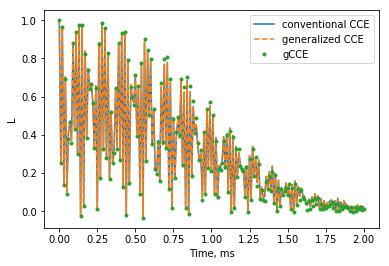

In [7]:
plt.plot(time_space, Lconv, label='conventional CCE')
plt.plot(time_space, Lgen, label='generalized CCE', ls='--')
plt.plot(time_space, Lmf, label='gCCE', ls='', marker='.')

plt.legend()
plt.xlabel('Time, ms')
plt.ylabel('L')

# VV in SiC
An example of computing FID with GIPAW computed A

In [2]:
# Set up unit cell with (a, b, c, alpha, beta, gamma)
sic = pc.bath.NSpinCell(3.073, 3.073, 10.053, 90, 90, 120, 'deg')
# z axis in cell coordinates
sic.zdir = [0, 0, 1]
# position of atoms
sic.add_atoms(('Si', [0.00000000, 0.00000000, 0.1880]),
              ('Si', [0.00000000, 0.00000000, 0.6880]),
              ('Si', [0.33333333, 0.66666667, 0.4380]),
              ('Si', [0.66666667, 0.33333333, 0.9380]),
              ('C', [0.00000000, 0.00000000, 0.0000]),
              ('C', [0.00000000, 0.00000000, 0.5000]),
              ('C', [0.33333333, 0.66666667, 0.2500]),
              ('C', [0.66666667, 0.33333333, 0.7500]))
# isotopes 
sic.add_isotopes(('29Si', 0.047), ('13C', 0.011))

# defect position in cell units
vsi_cell = [0, 0, 0.1880]
vc_cell = [0, 0, 0]

# Generate bath spin positions
atoms = sic.gen_supercell(200, remove=[('Si', vsi_cell),
                                       ('C', vc_cell)])

In [3]:
# Read GIPAW results
exatoms = pc.bath.read_qe('./gipaw/pw.in',
                             './gipaw/gipaw.out')

# Prepare rotation matrix to alling with z axis of generated atoms
# This matrix, acting on the [0, 0, 1] in Cartesian coordinates of GIPAW output
# Should produce [a, b, c] vector, alligned with zdirection of the NSpinCell
M = np.array([[0, 0, -1],
              [0, -1, 0],
              [-1, 0, 0]])

# Cell coordinates to change coordinates in exatoms from cell to cartesian
cell = np.array([[20.272033, 0.000000, 0.000000],
                 [0.000000, 26.811944, 0.000000],
                 [0.000000, 0.000000, 27.863846]])

# Position of (0,0,0) point in cell coordinates
center = [0.6, 0.5, 0.5]
exatoms = pc.bath.transform(
    exatoms, center=center, cell=cell, rotation_matrix=M, style='row', inplace=False)


In [8]:
# Setting up CCE calculations
pos = sic.cell_to_cartesian(vsi_cell)
N = 0
CCE_order = 2
r_bath = 40
r_dipole = 8
time_space = np.linspace(0, 0.01, 501)

B = np.array([0, 0, 500])
calc = pc.Simulator(1, pos, [0, 0, 1], [0, 1, 0])

ntype = calc.add_spintype(('13C', 1 / 2, 6.72828),
                          ('29Si', 1 / 2, -5.3188))

nspin = calc.read_bath(atoms, r_bath,
                       external_bath=exatoms)
subclusters = calc.generate_clusters(CCE_order, r_dipole=r_dipole)

Number of atoms with external HF: 35
Number of overall Nuclear spins is 796
Average number of neighbours is 5.3
Number of disjointed clusters is 11


In [9]:
L = calc.compute_coherence(time_space, B, N, as_delay=False)

/home/onizhuk/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0,0.5,'L')

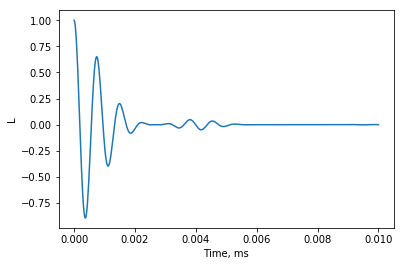

In [11]:
plt.plot(time_space, L)
plt.xlabel('Time, ms')
plt.ylabel('L')